In [2]:
import datetime
from math import exp, log
import matplotlib as mdates
from matplotlib import pyplot as plt
import numpy as np
from datetime import date
import pandas as pd
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from scipy.optimize import brentq

In [3]:
def generate_dates(start_date, n_months):
  dates = []
  for i in range (0, n_months, 12):
    dates.append(start_date + relativedelta(months=i))
  dates.append(start_date + relativedelta(months=n_months))
  return dates

In [4]:
class DiscountCurve:
  def __init__(self, pillars, dfs):
    self.start_date = pillars[0]
    self.pillars = [(p-self.start_date).days for p in pillars]
    self.log_dfs = [log(df) for df in dfs]

  def df(self, d):
    d_days = (d-self.start_date).days
    if d_days < 0:
      print ("Doesn't make sense to ask a discount factor in the past.")
      return None
    elif d_days > self.pillars[-1]:
      print ("np.interp does not allow to extrapolate.")
      return None
    else:
      return exp(np.interp(d_days, self.pillars, self.log_dfs))

In [49]:
class ForwardRateCurve:
  def __init__(self, pillars, rates):
    self.start_date = pillars[0]
    self.pillar_days = [(p-pillars[0]).days/365 for p in pillars]
    self.rates = rates

  def interp_rate(self, d):
    d_frac = (d-self.start_date).days/365
    if d_frac < self.pillar_days[0] or d_frac > self.pillar_days[-1]:
      print ("Cannot extrapolate rates.")
      return None, None
    else:
      return d_frac, np.interp(d_frac, self.pillar_days, self.rates)

  def forward_rate(self, d1, d2):
    d1_frac, r1 = self.interp_rate(d1)
    d2_frac, r2 = self.interp_rate(d2)
    if d1_frac is None or d2_frac is None:
      return None
    else:
      return ((r2*d2_frac - r1*d1_frac)/(d2_frac - d1_frac))*0.01

In [6]:
class OvernightIndexSwap:
  def __init__(self, nominal, start_date, maturity_months, fixed_rate):
      self.start_date = start_date
      self.nominal = nominal
      self.fixed_rate = fixed_rate
      self.payment_dates = generate_dates(start_date, maturity_months)

  def npv_floating(self, dc):
    return self.nominal * (dc.df(self.payment_dates[0]) - dc.df(self.payment_dates[-1]))

  def npv_fixed(self, dc):
    val = 0
    for i in range(1, len(self.payment_dates)):
        val += dc.df(self.payment_dates[i]) * \
                (self.payment_dates[i] - self.payment_dates[i-1]).days/360
    return self.nominal*self.fixed_rate*val

  def npv(self, dc):
    return self.npv_floating(dc) - self.npv_fixed(dc)

In [7]:
def of(dfs, pillars, swaps):
  dfs = np.insert(dfs, 0, 1)
  dc = DiscountCurve(pillars, dfs)
  val = 0
  for s in swaps:
    val += s.npv(dc)**2
  return val

In [8]:
def make_swaps(data):
  pricing_date = date.today()
  pillar_dates = [pricing_date]
  swaps = []
  for i in range(len(data)):
    swap = OvernightIndexSwap(1e5, pricing_date,
                              data.loc[i, 'months'],
                              data.loc[i, 'quotes']*0.01)
    swaps.append(swap)
    pillar_dates.append(swap.payment_dates[-1])
  return swaps, pillar_dates

swaps, pillar_dates = make_swaps(pd.read_excel('ois_quotes.xlsx'))

In [9]:
dfs0 = [0.5 for _ in range(len(swaps))]
bounds = [(0.01, 10) for _ in range(len(swaps))]
result = minimize(of, dfs0, bounds=bounds, args=(pillar_dates, swaps))
print(result)

      fun: 5.886934885609709e-06
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.57145218e-03,  5.02676695e-01,  1.40785128e+00,  1.69013087e+00,
        1.29421762e+00,  4.34745869e-01,  2.52219002e-02, -4.51896643e-02,
       -8.37635882e-02, -8.84969901e-02, -6.47249017e-02, -8.16859019e-01,
        6.43543220e-02,  3.82459671e+00,  2.54324418e+00,  1.87936624e+00,
        1.42518260e+00,  1.65906012e+00,  1.84945068e+00,  2.20441852e+00,
        2.56672042e+00,  2.99888754e+00,  2.91202676e+00,  1.15983706e+00,
        2.33094816e+00, -2.50120141e+00,  2.96246134e+00,  8.12536409e+00,
        2.97398603e+00,  2.83470514e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1054
      nit: 11
     njev: 34
   status: 0
  success: True
        x: array([0.99945138, 0.99831201, 0.99696347, 0.99525677, 0.99340215,
       0.99136706, 0.9892002 , 0.98696958, 0.98469213, 0.98239148,
       0.98001276, 0.97763574, 0.9638143 , 0.9504458

In [10]:
discount_factors = result["x"]
discount_factors

array([0.99945138, 0.99831201, 0.99696347, 0.99525677, 0.99340215,
       0.99136706, 0.9892002 , 0.98696958, 0.98469213, 0.98239148,
       0.98001276, 0.97763574, 0.9638143 , 0.95044587, 0.92527826,
       0.90036952, 0.8752759 , 0.85061109, 0.8265085 , 0.80234949,
       0.77842018, 0.75456742, 0.73127098, 0.70888994, 0.64940464,
       0.58284654, 0.54160531, 0.50880545, 0.44281208, 0.39008517])

In [11]:
today = date.today()
dfs = np.insert(discount_factors, 0, 1)
dc = DiscountCurve(pillar_dates, dfs)
df_date = today + relativedelta(days=195)
df0 = dc.df(df_date)
print ("discount factor at {}: {:.4f}".format(df_date, df0))

discount factor at 2023-08-27: 0.9904


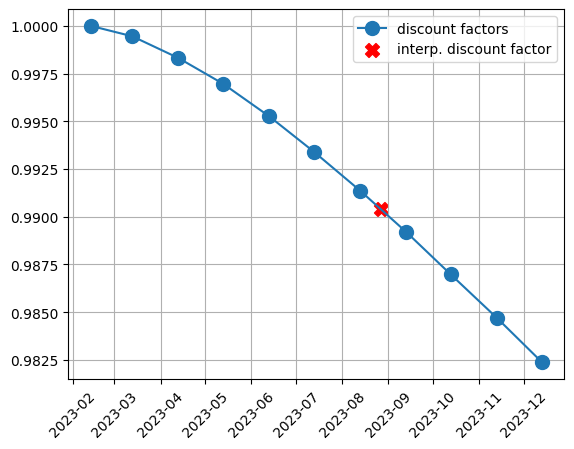

In [12]:
plt.plot(pillar_dates[:11], dfs[:11], marker='o', markersize=10, label="discount factors")
plt.scatter(df_date, df0, marker='X', s=100, color='red', label='interp. discount factor')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
#plt.show()
plt.savefig("linear_discount_curve.png")

In [65]:
today = date.today()
maturity = date(2027, 3, 5)
ed = pd.read_excel('euribor_1M_curve.xlsx', sheet_name="EURIBOR1M")
ld = pd.read_excel('libor_3M_curve.xlsx', sheet_name="USDLIBOR3M")
pillars_eur = [today + relativedelta(months=i) for i in ed['months']]
pillars_libor = [today + relativedelta(months=i) for i in ld['months']]
rates_eur = ed['rates']
rates_libor = ld['rates']
fc_eur = ForwardRateCurve(pillars_eur, rates_eur)
fc_lib = ForwardRateCurve(pillars_libor, rates_libor)
print(fc_eur.forward_rate(today, maturity))

0.030260273972602742


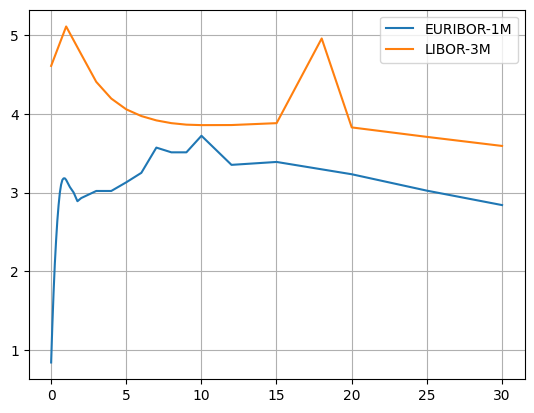

In [14]:
plt.plot(fc_eur.pillar_days, fc_eur.rates, label="EURIBOR-1M")
plt.plot(fc_lib.pillar_days, fc_lib.rates, label='LIBOR-3M')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print(fc_eur.rates)

0     0.845
1     1.300
2     1.730
3     2.090
4     2.390
5     2.640
6     2.840
7     3.000
8     3.100
9     3.160
10    3.180
11    3.180
12    3.160
13    3.070
14    3.000
15    2.890
16    2.930
17    3.020
18    3.020
19    3.130
20    3.250
21    3.570
22    3.510
23    3.510
24    3.720
25    3.351
26    3.388
27    3.232
28    3.024
29    2.841
Name: rates, dtype: float64


In [16]:
print(fc_lib.rates)

0     4.606
1     5.106
2     4.753
3     4.404
4     4.192
5     4.055
6     3.970
7     3.915
8     3.880
9     3.861
10    3.855
11    3.856
12    3.880
13    4.954
14    3.826
15    3.706
16    3.591
Name: rates, dtype: float64


In [17]:
def generate_dates(start_date, n_months, tenor_months=12):
    dates = []
    for n in range(0, n_months, tenor_months):
        dates.append(start_date + relativedelta(months=n))
    dates.append(start_date + relativedelta(months=n_months))
    return dates

generate_dates(date.today(), 16, 3)

[datetime.date(2023, 2, 13),
 datetime.date(2023, 5, 13),
 datetime.date(2023, 8, 13),
 datetime.date(2023, 11, 13),
 datetime.date(2024, 2, 13),
 datetime.date(2024, 5, 13),
 datetime.date(2024, 6, 13)]

In [18]:
class CrossCurrencySwap:
    def __init__(self, start_date, nominal_dom, nominal_for, fc_eur, fc_lib, tenor, maturity_years, fx_rates):
        self.nominal_dom = nominal_dom
        self.nominal_for = nominal_for
        self.fc_eur = fc_eur
        self.fc_lib = fc_lib
        self.fx_rates = fx_rates
        self.dates = generate_dates(start_date, 12 * maturity_years,tenor)

    def npv_dom(self, dc, spread):
        val = 0
        for j in range(1, len(self.dates)):
            F1 = self.fc_eur.forward_rate(self.dates[j], self.dates[j - 1]) + spread
            tau = (self.dates[j] - self.dates[j - 1]).days / 360
            P = dc.df(self.dates[j])
            val += F1 * tau * P
        val += dc.df(self.dates[j]) - dc.df(self.dates[0])
        return val * self.nominal_dom


    def npv_for(self, dc):
        val = 0
        for j in range(1, len(self.dates)):
            F2 = self.fc_lib.forward_rate(self.dates[j - 1], self.dates[j])
            tau = (self.dates[j] - self.dates[j - 1]).days / 360
            P = dc.df(self.dates[j])
            val += F2 * tau * P
        val += dc.df(self.dates[j]) - dc.df(self.dates[0])
        val *= self.nominal_for * self.fx_rates
        return val



    def npv_tot(self, spread, dc):
        npv_dom = self.npv_dom(dc, spread)
        npv_for = self.npv_for(dc)
        return (npv_for - npv_dom)

In [19]:
contracts = pd.read_csv('xcs_data.csv')
print(contracts)
fx_rates = pd.read_csv('fx_rates.csv', index_col="currencies")
print(fx_rates)

   nominal_dom  nominal_for  maturity  tenor currencies
0   30000000.0   25000000.0         2      3     EURUSD
1    1500000.0    1500000.0         3      3     EURGBP
2   15000000.0   15000000.0         4      3     USDEUR
3    5500000.0    6500000.0         5      3     EURUSD
4   10000000.0   12000000.0         3      3     EURGBP
            fx_rate
currencies         
EURUSD         1.15
EURGBP         0.86
USDGBP         0.75


In [52]:
start_date = date.today()
for i in range(len(contracts)):
  if contracts.currencies[i][:3] == "EUR":
    CCS = CrossCurrencySwap(start_date,
                            contracts.nominal_dom[i],
                            contracts.nominal_for[i],
                            fc_eur,
                            fc_lib,
                            3,
                            contracts.maturity[i],
                            1/fx_rates.fx_rate[contracts.currencies[i]])
  else:
    cur = contracts.currencies[i][-3:] + contracts.currencies[i][:3]
    CCS = CrossCurrencySwap(start_date,
                            contracts.nominal_for[i],
                            contracts.nominal_dom[i],
                            fc_eur,
                            fc_lib,
                            3,
                            contracts.maturity[i],
                            1/fx_rates.fx_rate[cur])

  x = CCS.npv_tot(0, dc)
  print(x)
  spread = brentq(CCS.npv_tot, -0.5, 0.5, args=(dc,))
  print(spread)


715598.9701622075
0.012060566842202969
74687.49178461226
0.01702024770802618
565925.9448962152
0.009805370224552856
259639.56041032105
0.009949573976590853
624658.6028216323
0.021352660061809914


In [21]:
print(CCS.npv_dom(dc, spread))
print(CCS.npv_for(dc))

760451.9455453013
760451.9455453029


[2.413792315574026, 2.192825888630084, 1.7020247708026182, 1.4559951897957557, 1.1907600051950462, 0.9769036547139842, 0.6150713169933153, 0.6199922541034242, 0.5898644256030039]
[3.16, 2.93, 3.0199999999999996, 3.02, 3.1300000000000003, 3.25, 3.5700000000000003, 3.51, 3.51]
[5.106, 4.753, 4.404, 4.192, 4.055000000000001, 3.9699999999999998, 3.914999999999999, 3.88, 3.8609999999999993]


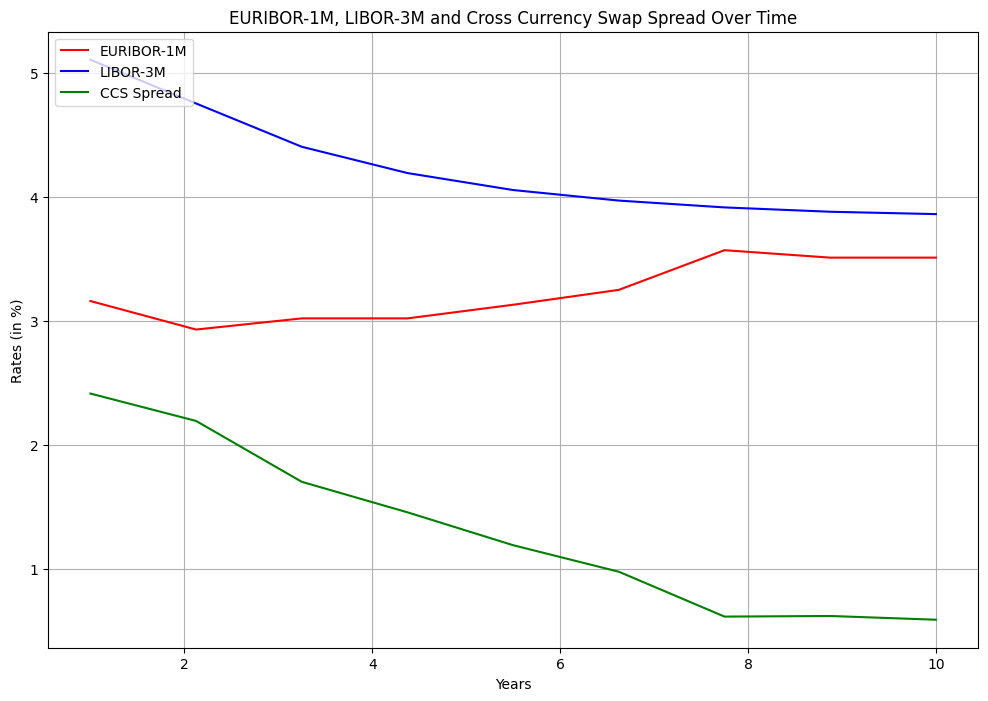

In [76]:
start_date = date.today()
a=[]
spreads = []
euribor = []
libor = []
for i in range(1,10):
    d = start_date + relativedelta(years=i)
    euribor.append(fc_eur.forward_rate(start_date, d)*100)
    libor.append(fc_lib.forward_rate(start_date, d)*100)
    a.append(CrossCurrencySwap(start_date,
                                contracts.nominal_dom[1],
                                contracts.nominal_for[1],
                                fc_eur,
                                fc_lib,
                                3,
                                i,
                                1/fx_rates.fx_rate[contracts.currencies[1]]))
    spreads.append((brentq(a[i-1].npv_tot, -0.5, 0.5, args=(dc,)))*100)
print(spreads)
print(euribor)
print(libor)
t = np.linspace(1, 10, 9)

plt.figure(figsize=(12, 8))
plt.title("EURIBOR-1M, LIBOR-3M and Cross Currency Swap Spread Over Time")
plt.xlabel("Years")
plt.ylabel("Rates (in %)")
plt.plot(t, euribor, color='red', label='EURIBOR-1M')
plt.plot(t, libor, color='blue', label='LIBOR-3M')
plt.plot(t, spreads, color='green', label='CCS Spread')
plt.legend(loc='upper left')
plt.grid(True)
